<a href="https://colab.research.google.com/github/Rigelabs/tensor_flow/blob/master/adv_flower_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import logging
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import tensorflow as tf
import os
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Download the Flowers Dataset using TensorFlow Datasets
In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the TensorFlow Datasets documentation you will see that the name of the Flowers dataset is tf_flowers. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use tfds.splits to split this training set into to a training_set and a validation_set. Do a [70, 30] split such that 70 corresponds to the training_set and 30 to the validation_set. Then load the tf_flowers dataset using tfds.load. Make sure the tfds.load function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.

In [12]:

(training_set, validation_set), dataset_info = tfds.load('tf_flowers' ,
                                                 with_info = True,
                                                 as_supervised =True,
                                                 split =[
                                                         'train[:70%]','train[70%:]'
                                                 ]
                                               ) 



In [4]:
dataset_info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.0,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

In [13]:
total_num_examples = dataset_info.splits['train'].num_examples
num_classes = dataset_info.features['label'].num_classes
num_training_examples = int(total_num_examples *0.7)
num_validation_examples = int(total_num_examples * 0.3)
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



# Reformat Images and Create Batches
In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an image and a label as arguments and should return the new image and corresponding label. Then create training and validation batches of size 32.

In [14]:
IMAGE_RES =224
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [15]:
#Use TensorFlow Hub to do Transfer Learning.

URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(URL, input_shape=(IMAGE_RES,IMAGE_RES,3))

#Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.
feature_extractor.trainable = False

In [16]:
#wrap the hub layer in a tf.keras.Sequential model, and add a new classification layer.
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(5)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [17]:
#Train the model
model.compile(optimizer='adam', loss= tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])
EPOCHS =10

history = model.fit(train_batches,steps_per_epoch=BATCH_SIZE,validation_data=validation_batches,epochs=EPOCHS)


Epoch 1/10
32/32 [==============================] - 4s 128ms/step - loss: 1.1164 - accuracy: 0.5615 - val_loss: 0.6898 - val_accuracy: 0.7629
Epoch 2/10
32/32 [==============================] - 3s 105ms/step - loss: 0.6028 - accuracy: 0.7979 - val_loss: 0.4867 - val_accuracy: 0.8374
Epoch 3/10
17/32 [==============>...............] - 2s 143ms/step - loss: 0.4894 - accuracy: 0.8369 - val_loss: 0.4497 - val_accuracy: 0.8529


In [23]:
#Check the class Names
class_names =np.array(dataset_info.features['label'].names)

##Run an image batch through the model and convert the indices to class names
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch =image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch =model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis = -1)
predicted_classnames= class_names[predicted_ids]
predicted_classnames

array(['roses', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'tulips',
       'dandelion', 'dandelion', 'roses', 'sunflowers', 'tulips',
       'tulips', 'roses', 'roses', 'sunflowers', 'daisy', 'sunflowers',
       'sunflowers', 'roses', 'tulips', 'tulips', 'roses', 'daisy',
       'sunflowers', 'roses', 'tulips', 'dandelion', 'dandelion',
       'dandelion', 'sunflowers', 'tulips', 'tulips'], dtype='<U10')

In [24]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [2 0 0 0 1 2 0 0 4 3 2 2 4 4 3 1 2 3 4 2 2 2 1 3 4 2 0 0 0 3 2 2]
Predicted labels:  [4 0 0 0 1 2 0 0 4 3 2 2 4 4 3 1 3 3 4 2 2 4 1 3 4 2 0 0 0 3 2 2]


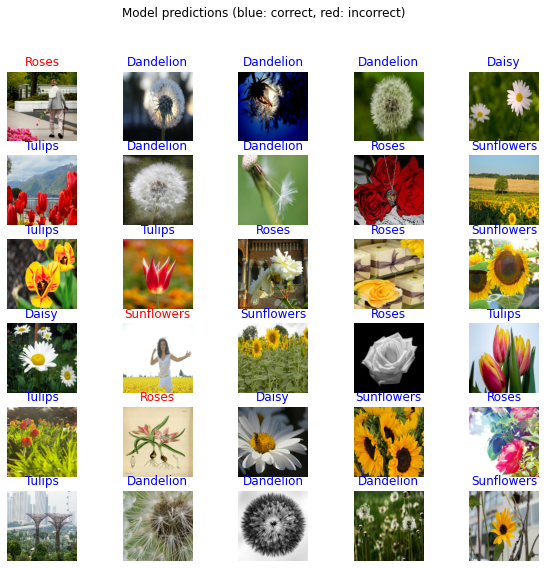

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_classnames[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

#Save as Keras .h5 model
Now that we've trained the model, we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correpond to the current time stamp.

In [28]:
import time
t = time.time()

export_path = "./{}.h5".format(int(t))

print(export_path)

model.save(export_path)

./1596524650.h5


You can later recreate the same model from this file, even if you no longer have access to the code that created the model.

This file includes:

1.The model's architecture

2.The model's weight values (which were learned during training)

3.The model's training config (what you passed to compile), if any

4.The optimizer and its state, if any (this enables you to restart training where you left off)

In [29]:
reloaded = tf.keras.models.load_model(export_path,
                                      custom_objects = {'KerasLayer': hub.KerasLayer})
reloaded.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
#We can check that the reloaded model and the previous model give the same result

result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

(abs(result_batch -reloaded_result_batch)).max()

#As we can see, the reult is 0.0, which indicates that both models made the same predictions on the same batch of images.

0.0

In [31]:
#Retrain the reloaded models
EPOCHS = 10
history = reloaded.fit(train_batches,
                    epochs=EPOCHS, steps_per_epoch =32,
                    validation_data=validation_batches)

Epoch 1/10
32/32 [==============================] - 4s 131ms/step - loss: 0.4000 - accuracy: 0.2559 - val_loss: 0.4074 - val_accuracy: 0.2125
Epoch 2/10
32/32 [==============================] - 3s 108ms/step - loss: 0.3809 - accuracy: 0.2441 - val_loss: 0.3643 - val_accuracy: 0.2470
Epoch 3/10
17/32 [==============>...............] - 2s 145ms/step - loss: 0.3379 - accuracy: 0.2457 - val_loss: 0.3556 - val_accuracy: 0.2398


In [33]:
#saving model using saved_model.save()

t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

!ls {export_path_sm}

./1596526813
assets	saved_model.pb	variables


# Export as SavedModel
You can also export a whole model to the TensorFlow SavedModel format. SavedModel is a standalone serialization format for Tensorflow objects, supported by TensorFlow serving as well as TensorFlow implementations other than Python. A SavedModel contains a complete TensorFlow program, including weights and computation. It does not require the original model building code to run, which makes it useful for sharing or deploying (with TFLite, TensorFlow.js, TensorFlow Serving, or TFHub).

The SavedModel files that were created contain:

> 1. A TensorFlow checkpoint containing the model weights.
> 2. A SavedModel proto containing the underlying Tensorflow graph. Separate graphs are saved for prediction (serving), train, and evaluation. If the model wasn't compiled before, then only the inference graph gets exported.
> 3. The model's architecture config, if available.

Let's save our original model as a TensorFlow SavedModel. To do this we will use the tf.saved_model.save() function. This functions takes in the model we want to save and the path to the folder where we want to save our model.

This function will create a folder where you will find an assets folder, a variables folder, and the saved_model.pb file

In [34]:
reloaded_sm = tf.saved_model.load(export_path_sm)

In [35]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)


reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

./1596526923
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 2,230,277
Non-trainable params: 34,112
_________________________________________________________________


In [36]:
#Now, let's use the reloaded_sm)keras (reloaded Keras model from our SavedModel) to make predictions on a batch of images.
result_batch = model.predict(image_batch)
reload_sm_keras_result_batch = reload_sm_keras.predict(image_batch)

(abs(result_batch - reload_sm_keras_result_batch)).max()

0.0

You can download the SavedModel to your local disk by creating a zip file. We wil use the `-r` (recursice) option to zip all subfolders. 

In [39]:
!zip -r model.zip {export_path_sm}

updating: 1596526923/ (stored 0%)
updating: 1596526923/saved_model.pb (deflated 92%)
updating: 1596526923/assets/ (stored 0%)
updating: 1596526923/variables/ (stored 0%)
updating: 1596526923/variables/variables.data-00000-of-00001 (deflated 8%)
updating: 1596526923/variables/variables.index (deflated 78%)


In [41]:
#Once the file is zipped, you can download it to your local disk.

try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>